# Data Cleaning
## Overview
- Load in data used in the analyses
- Understand the structure, granularity, and quality of the data
- Clean up the data for further inspection

## Datasets
1. **Oakland neighborhoods**
    - GeoJSON format data to plot different neighborhoods in Oakland. The idea here is to be able to aggregate any values of interest (e.g., incidents of grafitti) by easily-identifiable neighborhoods.
1. **Oakland city service requests**
    - CSV file containing requests (e.g., potholes, illegal dumping, etc.) from residents.

In [1]:
# Standard tools for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tools specific for geospatial data analysis
from shapely.geometry import shape, mapping, Point, Polygon
import geopandas as gpd

# Tools from the Python Standard Library
import os
import sys
import re

from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

First, let's take a look at files that are available:

In [2]:
DATADIR = '../data/'
!ls $DATADIR

Service_requests_received_by_the_Oakland_Call_Center.csv
neighborhoods
oakland_neighborhoods.geojson
residential_zones_300_ft_of_industrial_areas.geojson
stations.geojson
tracks.geojson


## 1. Oakland neighborhood classification
- A GeoJSON file classifying the areas in Oakland into neighborhoods was pulled from https://data.oaklandnet.com/Property/Oakland-Neighborhoods/7zky-kcq9 on 22/11/17.
- The downloaded file was renamed, replacing spaces with underscores, and setting all letters to lowercase for convenience.

Let's read in this GeoJSON file:

### Note
It wasn't trivial to get this working! I spent quite some time hacking to get this to come out right (ultimately, it just came down to finding the right versions to use). Reading GeoJSON into Geopandas DataFrames should be straightforward, but I was met with quite a few errors. After doing some tracking, I found that the right combination was using installing `shapely` and `geopandas` from `pip` instead of `conda-forge`.

In [3]:
neighborhoods = gpd.read_file(DATADIR + 'oakland_neighborhoods.geojson')

In [4]:
display(neighborhoods.head())
display(neighborhoods.tail())

,name,description,geometry
0,Acorn/ Acorn Industrial,,POINT (-122.308714010677 37.802146145243)
1,Adams Point,,POINT (-122.254661526017 37.8121177617939)
2,Allendale,,POINT (-122.203566466228 37.7871405525981)
3,Arroyo Viejo,,POINT (-122.178464360722 37.7600613799457)
4,Bancroft Business/ Havenscourt,,POINT (-122.184941350471 37.7669285553085)


,name,description,geometry
269,Upper Rockridge,,"(POLYGON ((-122.219555006624 37.832981772973, ..."
270,Waverly,,"(POLYGON ((-122.261262247923 37.811458543436, ..."
271,Webster,,"(POLYGON ((-122.165951274503 37.7532857075336,..."
272,Woodland,,"(POLYGON ((-122.177602684022 37.7536107490519,..."
273,Woodminster,,"(POLYGON ((-122.178433674265 37.8037393938781,..."


There's an empty `description` column that we can remove:

In [5]:
del neighborhoods['description']

As we see, this GeoDataFrame contains both points and polygons. The points are used as markers (e.g., on interactive maps), while the polygons actually give us the shape. Let's move all the points to a separate column called `centers`, so we can have a single point to characterize the neighborhood, if needed.

In [6]:
# Make a temporary DataFrame only containing points
neighborhood_centers = neighborhoods[(neighborhoods.geom_type == 'Point')]

# Remove points from the neighborhood DataFrame
neighborhoods = neighborhoods[~(neighborhoods.geom_type == 'Point')]

# Reset the indexing to 0
neighborhoods.reset_index(inplace=True)
del neighborhoods['index']

Get the longitude and latitude from each center coordinate, and add that to the main neighborhoods DataFrame:

In [7]:
center_lon = neighborhood_centers['geometry'].apply(lambda x: x.coords[0][0])
center_lat = neighborhood_centers['geometry'].apply(lambda x: x.coords[0][1])

In [8]:
neighborhoods['center_lon'] = center_lon
neighborhoods['center_lat'] = center_lat

In [9]:
neighborhoods.head()

,name,geometry,center_lon,center_lat
0,Acorn/ Acorn Industrial,"(POLYGON ((-122.280212520786 37.8025938890711,...",-122.308714,37.802146
1,Adams Point,"(POLYGON ((-122.247844000895 37.810057515347, ...",-122.254662,37.812118
2,Allendale,"(POLYGON ((-122.196320300415 37.7863349418319,...",-122.203566,37.787141
3,Arroyo Viejo,"(POLYGON ((-122.170503431087 37.759584556553, ...",-122.178464,37.760061
4,Bancroft Business/ Havenscourt,"(POLYGON ((-122.177112657994 37.7654884250132,...",-122.184941,37.766929


Let's check these neighborhoods out!

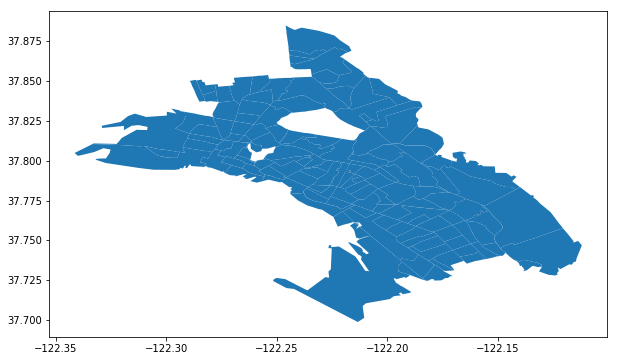

In [10]:
f, ax = plt.subplots()
neighborhoods.plot(ax=ax);

### Maps

Notice how this just gives us the shapes of our neighborhoods without any context. Later on, I will plot these neighborhoods on top of a map (e.g., satellite images) so we get an idea of where these are located with respect to other features we are familiar with. To do this, we will use `basemap`. It's worth noting that `basemap` is being replaced with `cartopy`, but since I'm somewhat familiar with `basemap` for the time being :).

We will use the same coordinates from the above plot to get our $x$ and $y$ limits. In `basemap`, these will be referred to as the lower (upper) left (right) corner latitude (longitude) or llcrnlat, etc.

## 2. City Service Requests
- An Excel Spreadsheet containing service requests to the city was pulled on the afternoon of 11 December 2017. This record is regularly updated and contains the following information of interest:
    1. Request ID
    1. Date and time at which the request was registered in the system
    1. Source of service request (i.e., call, email, website)
    1. Description
    1. Request category (e.g., GRAFFITI)
    1. Request location (address and/or GPS coordinates)
    1. Status (open, closed, cancelled, etc.)
    1. Date and time at which the request was closed in the system
- The purpose for considering this data is to look at the frequency at which requests are made in different neighborhoods, as well as the distribution of times it takes to resolve issues.

First, we need to download this file since it's too big to have on GitHub (~88MB). I have the copy I used cached locally, but I can't come up with a perfect short-term solution for sharing this. As a result, I simply download from the source. This is not good for reproducibility, as we need to be able to ensure we are looking at the same data. But for the purpose of this assignment, downloading a fresh copy will only add a few days of new entries.

In [11]:
! wget -O ../data/Service_requests_received_by_the_Oakland_Call_Center.csv https://data.oaklandnet.com/api/views/quth-gb8e/rows.csv?accessType=DOWNLOAD

--2017-12-13 18:56:45--  https://data.oaklandnet.com/api/views/quth-gb8e/rows.csv?accessType=DOWNLOAD
Resolving data.oaklandnet.com... 52.206.140.199
Connecting to data.oaklandnet.com|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘../data/Service_requests_received_by_the_Oakland_Call_Center.csv’

../data/Service_req     [          <=>       ]  84.80M  2.04MB/s    in 37s     

Last-modified header invalid -- time-stamp ignored.
2017-12-13 18:57:23 (2.27 MB/s) - ‘../data/Service_requests_received_by_the_Oakland_Call_Center.csv’ saved [88922030]



In [12]:
service_requests = pd.read_csv(DATADIR + 'Service_requests_received_by_the_Oakland_Call_Center.csv')

In [13]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,REQADDRESS,STATUS,REFERREDTO,DATETIMECLOSED,SRX,SRY,COUNCILDISTRICT,BEAT
0,21090,07/01/2009 10:24:19 AM,Phone or Email,Yard Trimmings - Food Pail Request,RECYCLING,"532 BODEN WY\nCA, CA\n(37.807708, -122.248339)",CLOSED,NaN,07/27/2009 11:34:09 AM,6056502.139,2121252.658,CCD3,15X
1,21091,07/01/2009 11:14:09 AM,Phone or Email,City Services - Missed Recycling,RECYCLING,"699 BELLEVUE AV\nCA, CA\n(37.809762, -122.259388)",CLOSED,NaN,07/03/2009 11:10:08 AM,6053405.037,2122019.368,CCD3,14X
2,21092,07/01/2009 03:58:47 PM,Phone or Email,Yard Trimmings Service Issue (Residential),RECYCLING,"1633 84TH AV\nCA, CA\n(37.755521, -122.175515)",CLOSED,NaN,07/27/2009 11:33:58 AM,6077230.607,2101888.265,CCD6,34X
3,21093,07/01/2009 03:59:26 PM,Phone or Email,Yard Trimmings - Cart Request,RECYCLING,"3367 DWIGHT WY\nCA, CA\n(37.868229, -122.243706)",CLOSED,NaN,07/03/2009 11:09:54 AM,6058207.824,2143299.182,CCD1,13Y
4,21094,07/01/2009 04:03:05 PM,Phone or Email,Residential Recycling - Oil - Kit Request,RECYCLING,"5777 GRISBORNE AV\nCA, CA\n(37.835057, -122.21...",CLOSED,NaN,07/03/2009 02:30:07 PM,6067161.057,2131022.692,CCD4,13Y


For now, I'll drop the `REFERREDTO`, `SRX`, `SRY`, `COUNCILDISTRICT`, and `BEAT` columns.

In [14]:
service_requests.drop(columns=['REFERREDTO', 'SRX', 'SRY', 'COUNCILDISTRICT', 'BEAT'], inplace=True)

In [15]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,REQADDRESS,STATUS,DATETIMECLOSED
0,21090,07/01/2009 10:24:19 AM,Phone or Email,Yard Trimmings - Food Pail Request,RECYCLING,"532 BODEN WY\nCA, CA\n(37.807708, -122.248339)",CLOSED,07/27/2009 11:34:09 AM
1,21091,07/01/2009 11:14:09 AM,Phone or Email,City Services - Missed Recycling,RECYCLING,"699 BELLEVUE AV\nCA, CA\n(37.809762, -122.259388)",CLOSED,07/03/2009 11:10:08 AM
2,21092,07/01/2009 03:58:47 PM,Phone or Email,Yard Trimmings Service Issue (Residential),RECYCLING,"1633 84TH AV\nCA, CA\n(37.755521, -122.175515)",CLOSED,07/27/2009 11:33:58 AM
3,21093,07/01/2009 03:59:26 PM,Phone or Email,Yard Trimmings - Cart Request,RECYCLING,"3367 DWIGHT WY\nCA, CA\n(37.868229, -122.243706)",CLOSED,07/03/2009 11:09:54 AM
4,21094,07/01/2009 04:03:05 PM,Phone or Email,Residential Recycling - Oil - Kit Request,RECYCLING,"5777 GRISBORNE AV\nCA, CA\n(37.835057, -122.21...",CLOSED,07/03/2009 02:30:07 PM


Just from looking at these, we can see that many requests look pretty boring (e.g., reporting missing trash pickup). Let's explore this more to see if we can find data that can tell us more.

In [16]:
display(service_requests['REQCATEGORY'].unique())
display(service_requests['SOURCE'].unique())
display(service_requests['STATUS'].unique())

array(['RECYCLING', 'ELECTRICAL', 'ILLDUMP', 'PARKS', 'ROW', 'STREETSW',
       'KOCB', 'OTHER', 'TRAFFIC', 'TREES', 'WATERSHED', 'SEWERS',
       'BLDGMAINT', 'DRAINAGE', 'TRAFFIC_ENGIN', 'METER_REPAIR',
       'GRAFFITI', 'FACILITIES', 'FIRE', nan, 'CUT_CLEAN', 'VEGCONTR',
       'CW_DIT_GIS', 'GIS', 'SURVEY', 'LAB', 'OPD'], dtype=object)

array(['Phone or Email', 'Email', 'SeeClickFix', 'Phone', 'Voicemail',
       'Website', 'City Attorney', 'Other'], dtype=object)

array(['CLOSED', 'OPEN', 'CANCEL', 'WOCREATE', 'REFERRED', 'UNFUNDED',
       'Pending', 'Cancel', 'PENDING'], dtype=object)

Let's take a look at the unfunded requests:

In [17]:
service_requests[service_requests['STATUS'] == 'UNFUNDED'].head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,REQADDRESS,STATUS,DATETIMECLOSED
461,313126,08/19/2009 09:59:07 AM,Phone or Email,Tree - Pruning,TREES,"5115 WEST STREET\nCA, CA\n(37.836327, -122.269...",UNFUNDED,NaN
919,334746,04/22/2010 02:07:52 PM,Phone or Email,Streets/Sidewalks - Curb & Gutter Repair,STREETSW,"1648 104TH AV\nCA, CA\n(37.740948, -122.16464)",UNFUNDED,NaN
1339,311488,07/29/2009 03:10:13 PM,Phone or Email,Tree - Pruning,TREES,"MARTIN LUTHER KING JR WY &amp; 57TH ST\nCA, CA...",UNFUNDED,NaN
1513,312376,08/11/2009 08:38:06 AM,Phone or Email,Streets - Street Deterioration,STREETSW,"PERKINS ST &amp; GRAND AV\nCA, CA\n(37.808964,...",UNFUNDED,NaN
1586,312589,08/12/2009 02:35:34 PM,Phone or Email,Streets - Street Deterioration,STREETSW,"MOUNTAIN BLVD &amp; ASCOT DR\nCA, CA\n(37.8182...",UNFUNDED,NaN


### Get GPS Coordinates

We will want the GPS coordinates for easier plotting later on. Let's do some regex-ing to clean those addresses/coordinates up:

In [18]:
service_requests['REQADDRESS'].head()

0       532 BODEN WY\nCA, CA\n(37.807708, -122.248339)
1    699 BELLEVUE AV\nCA, CA\n(37.809762, -122.259388)
2       1633 84TH AV\nCA, CA\n(37.755521, -122.175515)
3     3367 DWIGHT WY\nCA, CA\n(37.868229, -122.243706)
4    5777 GRISBORNE AV\nCA, CA\n(37.835057, -122.21...
Name: REQADDRESS, dtype: object

Here's a regex expression that can be used to pull GPS coordinates from the address column:

In [19]:
re.findall('[\d.]+, [\-\d.]+', service_requests['REQADDRESS'].iloc[3])

['37.868229, -122.243706']

We can use a function to perform this search and also return a tuple of GPS coordinates for us. I included this function in a script located at `scripts/oaktext.py`. The purpose for that is reuse, and the ability to test.*

<sub>* This is a bit of a contrived example for unit testing. </sub>

In [20]:
# Load the module that the scripts are stored in
sys.path.append("../scripts")

# Import the module for getting coordinates
from oaktext import get_coords

In [21]:
get_coords(service_requests['REQADDRESS'].iloc[1])

(37.809762, -122.259388)

In [22]:
service_requests['coordinates'] = service_requests['REQADDRESS'].apply(get_coords)

In [23]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,REQADDRESS,STATUS,DATETIMECLOSED,coordinates
0,21090,07/01/2009 10:24:19 AM,Phone or Email,Yard Trimmings - Food Pail Request,RECYCLING,"532 BODEN WY\nCA, CA\n(37.807708, -122.248339)",CLOSED,07/27/2009 11:34:09 AM,"(37.807708, -122.248339)"
1,21091,07/01/2009 11:14:09 AM,Phone or Email,City Services - Missed Recycling,RECYCLING,"699 BELLEVUE AV\nCA, CA\n(37.809762, -122.259388)",CLOSED,07/03/2009 11:10:08 AM,"(37.809762, -122.259388)"
2,21092,07/01/2009 03:58:47 PM,Phone or Email,Yard Trimmings Service Issue (Residential),RECYCLING,"1633 84TH AV\nCA, CA\n(37.755521, -122.175515)",CLOSED,07/27/2009 11:33:58 AM,"(37.755521, -122.175515)"
3,21093,07/01/2009 03:59:26 PM,Phone or Email,Yard Trimmings - Cart Request,RECYCLING,"3367 DWIGHT WY\nCA, CA\n(37.868229, -122.243706)",CLOSED,07/03/2009 11:09:54 AM,"(37.868229, -122.243706)"
4,21094,07/01/2009 04:03:05 PM,Phone or Email,Residential Recycling - Oil - Kit Request,RECYCLING,"5777 GRISBORNE AV\nCA, CA\n(37.835057, -122.21...",CLOSED,07/03/2009 02:30:07 PM,"(37.835057, -122.212352)"


In [24]:
service_requests.loc[1]

REQUESTID                                                     21091
DATETIMEINIT                                 07/01/2009 11:14:09 AM
SOURCE                                               Phone or Email
DESCRIPTION                        City Services - Missed Recycling
REQCATEGORY                                               RECYCLING
REQADDRESS        699 BELLEVUE AV\nCA, CA\n(37.809762, -122.259388)
STATUS                                                       CLOSED
DATETIMECLOSED                               07/03/2009 11:10:08 AM
coordinates                                (37.809762, -122.259388)
Name: 1, dtype: object

In [25]:
print('Number of entries with coordinates:', service_requests[service_requests['coordinates'].notnull()].shape[0])
print('Number of entries without coordinates:', service_requests[service_requests['coordinates'].isna()].shape[0])

Number of entries with coordinates: 402792
Number of entries without coordinates: 70883


Let's limit ourselves to the entries that have coordinates for us to plot (using the addresses provided is completely possible, but beyond the scope of our current analysis). As we see above, we still have a good amount of data to play with. It's worth noting that selecting only those with GPS coordinates may in fact be introducing a bias in our results, or it may in fact be a negiligble effect (e.g., the people responsible for data entry may not have entered the coordinates...).

In [26]:
service_requests = service_requests[service_requests['coordinates'].notnull()]
print(service_requests.shape)

(402792, 9)


In [27]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,REQADDRESS,STATUS,DATETIMECLOSED,coordinates
0,21090,07/01/2009 10:24:19 AM,Phone or Email,Yard Trimmings - Food Pail Request,RECYCLING,"532 BODEN WY\nCA, CA\n(37.807708, -122.248339)",CLOSED,07/27/2009 11:34:09 AM,"(37.807708, -122.248339)"
1,21091,07/01/2009 11:14:09 AM,Phone or Email,City Services - Missed Recycling,RECYCLING,"699 BELLEVUE AV\nCA, CA\n(37.809762, -122.259388)",CLOSED,07/03/2009 11:10:08 AM,"(37.809762, -122.259388)"
2,21092,07/01/2009 03:58:47 PM,Phone or Email,Yard Trimmings Service Issue (Residential),RECYCLING,"1633 84TH AV\nCA, CA\n(37.755521, -122.175515)",CLOSED,07/27/2009 11:33:58 AM,"(37.755521, -122.175515)"
3,21093,07/01/2009 03:59:26 PM,Phone or Email,Yard Trimmings - Cart Request,RECYCLING,"3367 DWIGHT WY\nCA, CA\n(37.868229, -122.243706)",CLOSED,07/03/2009 11:09:54 AM,"(37.868229, -122.243706)"
4,21094,07/01/2009 04:03:05 PM,Phone or Email,Residential Recycling - Oil - Kit Request,RECYCLING,"5777 GRISBORNE AV\nCA, CA\n(37.835057, -122.21...",CLOSED,07/03/2009 02:30:07 PM,"(37.835057, -122.212352)"


And since we are not using the address, let's just drop that column:

In [28]:
service_requests.drop(columns='REQADDRESS', inplace=True)

### Convert dates/times to datetime

Another piece of data that may be of interest to us is how long it took to close the request. For example, we can geospatially map out how long it took to close requests. To do this, let's first make sure the times are all in a common format.

In [29]:
service_requests.loc[:, 'DATETIMEINIT'] = pd.to_datetime(service_requests['DATETIMEINIT'],
                                                         format="%m/%d/%Y %I:%M:%S %p")
service_requests.loc[:, 'DATETIMECLOSED'] = pd.to_datetime(service_requests['DATETIMECLOSED'],
                                                           format="%m/%d/%Y %I:%M:%S %p")

What's the range of the dates here?

In [30]:
service_requests['DATETIMEINIT'].min(), service_requests['DATETIMEINIT'].max()

(Timestamp('2009-07-01 08:05:36'), Timestamp('2017-12-12 22:31:19'))

Neat, we have about 8 years of data here.

In [31]:
service_requests.loc[:, 'time_to_close'] = (service_requests['DATETIMECLOSED']
                                            - service_requests['DATETIMEINIT']).astype('timedelta64[D]')

In [32]:
service_requests.sort_values(by='time_to_close', ascending=False).head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,coordinates,time_to_close
14107,312392,2009-08-11 09:47:50,Phone or Email,Streets - Street Deterioration,STREETSW,CLOSED,2016-06-23 19:04:35,"(37.769321, -122.204457)",2508.0
72228,334963,2010-04-26 11:47:50,Phone or Email,Streets/Sidewalks - Curb & Gutter Repair,STREETSW,CLOSED,2016-09-28 13:06:24,"(37.77516, -122.188202)",2347.0
106570,348830,2010-09-29 11:46:21,Phone or Email,Streets - Potholes/Depression,STREETSW,CLOSED,2017-03-02 07:28:09,"(37.733121, -122.182413)",2345.0
59970,332554,2010-03-25 13:15:55,Phone or Email,Streets/Sidewalks - Curb & Gutter Repair,STREETSW,CLOSED,2016-06-23 19:04:13,"(37.76707, -122.197959)",2282.0
129887,358194,2011-01-21 10:03:01,Website,Streets/Sidewalks - Curb & Gutter Repair,STREETSW,CLOSED,2017-03-01 16:07:31,"(37.795346, -122.240054)",2231.0


We see that sometimes it takes years to close these! However, these are just the ones that are still open. If a request had never been closed, its value for `DATETIMECLOSED` will be `NaT` (i.e., not a time). As a result, we probably want a variable that gives us the time since opening. To do this, we can find the difference in time from when this was downloaded and when the request was opened.

In [33]:
# This dataset was downloaded on 11 Dec. 2017
t_0 = pd.datetime(2017, 12, 11)

In [34]:
service_requests.loc[:, 'time_since_init'] = (t_0 - service_requests['DATETIMEINIT']).astype('timedelta64[D]')

In [35]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,coordinates,time_to_close,time_since_init
0,21090,2009-07-01 10:24:19,Phone or Email,Yard Trimmings - Food Pail Request,RECYCLING,CLOSED,2009-07-27 11:34:09,"(37.807708, -122.248339)",26.0,3084.0
1,21091,2009-07-01 11:14:09,Phone or Email,City Services - Missed Recycling,RECYCLING,CLOSED,2009-07-03 11:10:08,"(37.809762, -122.259388)",1.0,3084.0
2,21092,2009-07-01 15:58:47,Phone or Email,Yard Trimmings Service Issue (Residential),RECYCLING,CLOSED,2009-07-27 11:33:58,"(37.755521, -122.175515)",25.0,3084.0
3,21093,2009-07-01 15:59:26,Phone or Email,Yard Trimmings - Cart Request,RECYCLING,CLOSED,2009-07-03 11:09:54,"(37.868229, -122.243706)",1.0,3084.0
4,21094,2009-07-01 16:03:05,Phone or Email,Residential Recycling - Oil - Kit Request,RECYCLING,CLOSED,2009-07-03 14:30:07,"(37.835057, -122.212352)",1.0,3084.0


We are in a good state to run further analyses on these data. Let's save it for further inspection:

In [36]:
RESULTSDIR = '../results/'
if not os.path.exists(RESULTSDIR):
    os.mkdir(RESULTSDIR)

In [37]:
service_requests.to_hdf(RESULTSDIR + '01-service_requests.h5', 'service_requests')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['SOURCE', 'DESCRIPTION', 'REQCATEGORY', 'STATUS', 'coordinates']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## 3. Gentrification Data
Here, I load gentrification data that I manually pulled from a map. While this is not ideal, it is meant to give us a first-order understanding of the relationship between gentrification and these contexual clues. In a more detailed study, these data would be generated from census figures.

The data here came from the map titled "Oakland Gentrification Map: 2000 Census - Present" at http://www.governing.com/gov-data/oakland-gentrification-maps-demographic-data.html.

From this map, the neighborhoods that have been gentrified appear to be:
- Prescott
- Clawson
- McClymonds
- Golden Gate
- Paradise Park
- Gaskill
- Santa Fe
- Bushrod
- Longfellow
- Old City/ Produce & Waterfront
- Chinatown
- Produce & Waterfront
- Civic Center
- Peralta / Laney
- Lakewide (lakeside?)
- Adams Point
- Cleveland Heights
- Grand Lake
- Ivy Hill
- Clinton
- North Kennedy Tract
- Hawthorne
- Oak Tree
- Reservoir Hill / Meadow Brook
- Maxwell Park
- Frick

According to the 1990-200- census, the following were gentrified:
- Temescal
- Mosswood

In [38]:
gentrified = ['Prescott', 'Clawson', 'McClymonds', 'Golden Gate', 'Paradise Park', 'Gaskill',
              'Santa Fe', 'Bushrod', 'Longfellow', 'Old City/ Produce & Waterfront', 'Chinatown',
              'Produce & Waterfront', 'Civic Center', 'Peralta/ Laney', 'Lakewide', 'Adams Point',
              'Cleveland Heights', 'Grand Lake', 'Ivy Hill', 'Clinton', 'North Kennedy Tract', 'Hawthorne',
              'Oak Tree', 'Reservoir Hill/ Meadow Brook', 'Maxwell Park', 'Frick', 'Temescal']

Take a look at these:

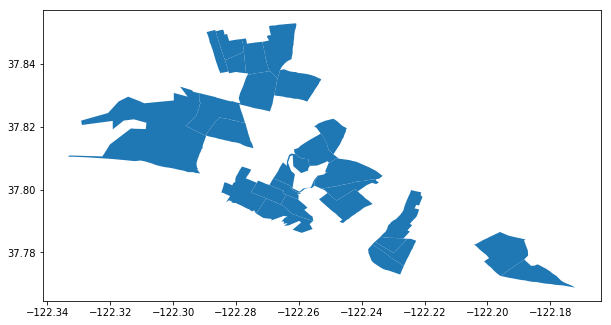

In [39]:
neighborhoods.loc[neighborhoods['name'].isin(gentrified)].plot()

Let's add whether or not the neighborhood is gentrified to the DataFrame. Because of the file format I'm saving to, we need to cast these booleans as integers:

In [40]:
neighborhoods['gentrified'] = neighborhoods['name'].isin(gentrified).astype(int)

Now save this to file for future use:

In [41]:
# The .shp format saves several files, so let's make a special subdirectory for that
if not os.path.exists(DATADIR + 'neighborhoods'):
    os.mkdir(DATADIR + 'neighborhoods')


neighborhoods.to_file(DATADIR + 'neighborhoods/oakland_neighborhoods_clean.shp',
                      driver='ESRI Shapefile')